In [37]:
import argparse
from ucbq_agent import UCBQAgent
from ucbq_environment import ModifiedRandomEnvironment
import time
import numpy as np

In [38]:
ERR_P = 0.1
ERR_N = 0.0

class PreProcessor:
    "Add noise to reward"
    def __init__(self, e_=0.1, e=0.3, normal=True, epsilon=1e-6):
        assert (np.abs(e_ + e - 1) > epsilon)
        self.normal = normal
        self.e_ = e_
        self.e = e
        self.epsilon = 1e-6
        # These are the noisy returns that are returned
        self.r1 = -1
        self.r2 = 0

    def noisy_reward(self, reward):
        n = np.random.random()
        # If we hit a negative reward, conver it to a poisitive
        # with a given prob. 
        # Not sure why the `< epsilone is here`
        # if np.abs(reward - self.r1) < self.epsilon:
        if reward == self.r1:
            if (n < self.e_):
                return self.r2
        else:
            if (n < self.e):
                return self.r1
        return reward

    def process_reward(self, reward):
        if self.normal:
            return reward

        r = self.noisy_reward(reward)
        return r
    
pre_processor = PreProcessor(normal=False, e_=ERR_N, e=ERR_P)

In [39]:
class PostProcessor:
    """
    Learning from surrogate reward
    following paper "Learning from noisy labels"
    """
    def __init__(self, smooth=False, surrogate=True,reverse=False, epsilon=1e-6):
        self.surrogate = surrogate
        self.smooth = smooth
        self.r_sets = {}
        self.r_smooth = {}
        self.r1 = -1
        self.r2 = 0
        self.counter = 0
        self.C = np.identity(2)
        self.epsilon = epsilon
        self.reverse = reverse

    def process_reward(self, reward):
        self.estimate_C()
        self.e_ = self.C[0, 1]
        self.e = self.C[1, 0]

        if self.surrogate:
            if np.abs(reward - self.r1) < self.epsilon:
                reward = ((1 - self.e) * self.r1 - self.e_ * self.r2) / (1 - self.e_ - self.e)
            else:
                reward = ((1 - self.e_) * self.r2 - self.e * self.r1) / (1 - self.e_ - self.e)

        return reward

    def estimate_C(self):
        if self.counter >= 100 and self.counter % 100 == 0:
            e_ = 0; e = 0
            # a = 0; b = 0
            # prob = 0

            self.count1 = 0
            self.count2 = 0
            for k in self.r_sets.keys():
                freq_count = collections.Counter(self.r_sets[k])
                if self.reverse:
                    truth, count = freq_count.most_common()[-1]
                else: truth, count = freq_count.most_common()[0]
                if truth == self.r1:
                    self.count1 += len(self.r_sets[k])
                else:
                    self.count2 += len(self.r_sets[k])

            for k in self.r_sets.keys():
                freq_count = collections.Counter(self.r_sets[k])
                # if self.e_ > 0.05:
                #    self.reverse = True
                #    self.counter = 0; self.r_sets = {}
                #    break

                if self.reverse:
                    truth, count = freq_count.most_common()[-1]
                else:
                    truth, count = freq_count.most_common()[0]
                prob_correct = float(count) / len(self.r_sets[k])
                if truth == self.r1:
                    if self.count1 > 2000:
                        prob_k = float(len(self.r_sets[k])) / self.count1
                        e_ += prob_k * (1 - prob_correct)
                    else: e_ = 0.0
                    # a += 2 * prob_k * prob_correct
                else:
                    prob_k = float(len(self.r_sets[k])) / self.count2
                    e += prob_k * (1 - prob_correct)
                    # b += 2 * prob_k * prob_correct

            # print prob
            # log_string(str(e_) + " " + str(e))
            self.C = np.array([[1-e_, e_], [e, 1-e]])

            # if self.counter >= 10000:
            #     self.counter = 0
            #    self.r_sets = {}

            # print self.C

    def smooth_reward(self, state, action, reward):
        if self.smooth:
            if (state, action) in self.r_smooth:
                if len(self.r_smooth[(state, action)]) >= 100:
                    self.r_smooth[(state, action)].pop(0)
                    self.r_smooth[(state, action)].append(reward)
                    return sum(self.r_smooth[(state, action)]) / float(len(self.r_smooth[(state, action)]))
                else:
                    self.r_smooth[(state, action)].append(reward)
            else:
                self.r_smooth[(state, action)] = [reward]

        return reward

    def collect(self, state, action, reward):
        if (state, action) in self.r_sets:
            self.r_sets[(state, action)].append(reward)
        else:
            self.r_sets[(state, action)] = [reward]
        self.counter += 1

#TODO: smoothing
post_processor = PostProcessor(smooth=False, surrogate=True)

In [40]:
all_chart_values = []

In [41]:
# Run the script with
# `python run_experiment.py -t 1`
# This will run a simulation trial, with a total length of 1 seconds.
# Participant answere will be given every 0.001 to 0.002 seconds.
# The participant "ture" level of feedback is 2.

# The script will output:
# - A list of actions taken, in the format: 
# `elapsed_time > action_taken -> reward_received`
# - The Q-table at the end of the trial,
# with rows representing states and columns representing acions
# - The total count of given actions taken in a given state, 
# with rows representing states and columns representing acions
# - Total timesteps (actions) taken
# - Total reward obtained

# The agent is rewrded `-1` for guessing the wrong feedback level (not 2),
# and `0` for guessing correctly

# parser = argparse.ArgumentParser()
# parser.add_argument("-t", "--TimeOut", help = "Stop script after n seconds")
# args = parser.parse_args()
timeOut = 10
num_states = 3
start_state = 1

In [42]:
def runner(adjust_rewards=None):
    agent = UCBQAgent(num_states=num_states, num_actions=num_states)
    env = ModifiedRandomEnvironment(current_state = start_state, num_states=num_states)

    start_time = time.time()
    t = 0

    episode_rewards = 0

    q_values_for_chart = []
    rewards = []

    state = start_state

    while True:
        elapsed_time = time.time() - start_time

        # Auto shut down scipt 
        if bool(timeOut) and (elapsed_time > float(timeOut)):
            break

        action = agent.choose_action(state) 
        # TODO: 
        # send_action_to_stream
        reward, next_state = env.step(action)
        
        rewards.append(reward)

        if adjust_rewards:
            reward = adjust_rewards(reward, state, action)
        
        # print(f"{round(elapsed_time, 2)} > {action} -> {reward}")
        
        agent.learn(state, action, reward, next_state)
        state = next_state

        episode_rewards += reward

        t += 1

        # Decay epsilon every 10 steps
        # TODO: not sure if this is valid theoretically
        if t % 10 == 0:
            if agent.epsilon > agent.epsilon_min:
                agent.epsilon *= agent.epsilon_decay # Decay epsilon
            
        if t % 10 == 0:
            q_values_for_chart.append(np.around(np.sum(agent.Q, axis=0), decimals=4))

    print(f'Q-table:')
    print(f'{np.around(agent.Q, decimals=4)}')
    print(f'Number of times action was taken:')
    print(f'{agent.N}')
    print(f'Total timesteps: {sum(sum(agent.N)) - 100}')
    print(f'Episode rewards: {episode_rewards}')

    import matplotlib.pyplot as plt
    # plt.plot(q_values_for_chart)
    fig = plt.gcf()
    fig.set_size_inches(18, 4)
    plt.plot(rewards)

    all_chart_values.append(q_values_for_chart)    

# Real rewards UCB Q-learning

Q-table:
[[-0.875 -0.875  0.   ]
 [-0.875 -0.875  0.   ]
 [-1.    -1.     0.   ]]
Number of times action was taken:
[[4.000e+00 4.000e+00 1.600e+01]
 [4.000e+00 4.000e+00 1.700e+01]
 [1.600e+01 1.600e+01 4.945e+03]]
Total timesteps: 4926.0
Episode rewards: -42


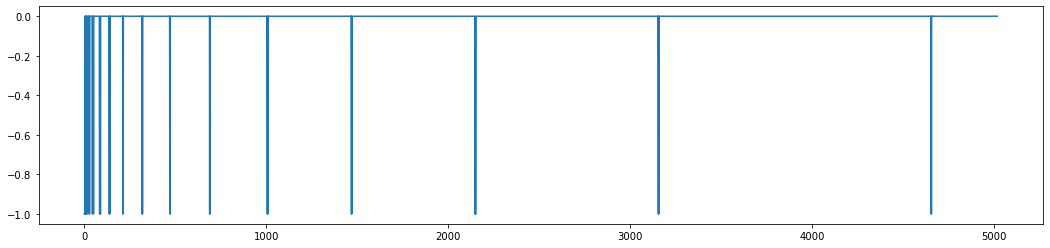

In [43]:
runner()

# Noisy rewards
- rewards are now noisy
- q-learner hasn't changed

Q-table:
[[-4.2276 -4.4901 -3.8175]
 [-4.5145 -4.5051 -4.1701]
 [-4.5646 -4.771  -2.3322]]
Number of times action was taken:
[[  13.   13.   43.]
 [  16.   14.   34.]
 [  40.   36. 4762.]]
Total timesteps: 4871.0
Episode rewards: -595


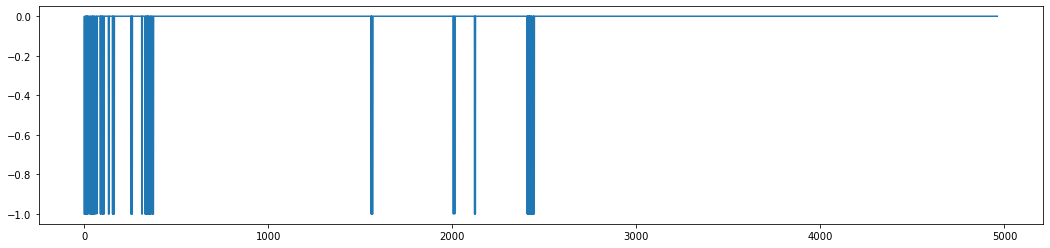

In [44]:
def adjust_rewards_noisy(reward, state, action):
    reward = pre_processor.process_reward(reward)
    reward = post_processor.smooth_reward(state, action, reward)
    return reward

runner(adjust_rewards_noisy)

# Surrogate rewards

In [45]:
import collections

Q-table:
[[-4.3242 -4.2962 -3.8611]
 [-4.4574 -4.173  -3.859 ]
 [-4.6437 -4.634  -1.0116]]
Number of times action was taken:
[[  13.   14.   35.]
 [  14.   13.   36.]
 [  35.   35. 4892.]]
Total timesteps: 4987.0
Episode rewards: -610


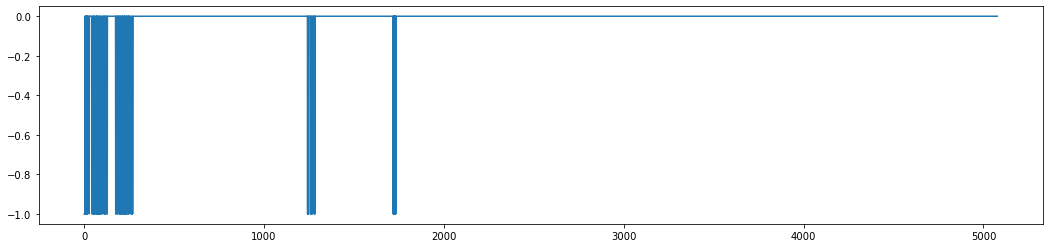

In [46]:
def adjust_rewards_surrogate(reward, state, action):
    reward = pre_processor.process_reward(reward)
    post_processor.collect(state, action, reward)
    reward = post_processor.process_reward(reward)
    reward = post_processor.smooth_reward(state, action, reward)
    return reward

runner(adjust_rewards_noisy)

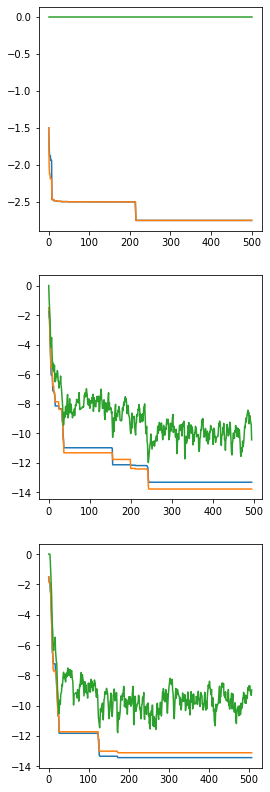

In [47]:
fig = plt.gcf()
fig.set_size_inches(4, 14)
plt.subplot(3, 1, 1)
plt.plot(all_chart_values[0])
plt.subplot(3, 1, 2)
plt.plot(all_chart_values[1])
plt.subplot(3, 1, 3)
plt.plot(all_chart_values[2])


# Custom simplified surrogate rewards

In [ ]:
#TODO